# Importing libraries:

In [56]:
import pandas as pd;
import numpy as np;
import sklearn
import matplotlib.pyplot as plt
import time

# months to evaluate model on
date = 2018090000

# for later use
features_num = 14

# lists to append results
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []

# Import data; fill nan values; split data intro train and test:

In [57]:
data = pd.read_csv('Data_set_1_smaller_(1).csv', index_col = 0)

# set predictive window according with tuning best results
data = data.loc[data.index > date, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values in the whole data set
data.fillna(data.mean(), inplace = True)

from sklearn.model_selection import train_test_split

# divide data into train and test 
data_train, data_test = train_test_split(
         data, test_size = 0.15, shuffle=False)

# Apply feature scaling:

In [58]:
from sklearn.preprocessing import MinMaxScaler

# data scaling
sc_X = MinMaxScaler()
data_train = sc_X.fit_transform(data_train)
data_test = sc_X.transform(data_test)

# Importing the Keras libraries and packages:

In [59]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping

# Need to process data with spike occurences in the same way as features and offers:
(Required to evaluate predictions in both normal regions and spike regions)

In [60]:
# download data for shaded area
data = pd.read_csv('Spike_binary_1std.csv', index_col = 0)

# set predictive window according with tuning best results
data = data.loc[data.index > date, :]

# make sure shaded area will correspond to values outputed by LSTM
data.reset_index(drop = True, inplace = True)

# fill_nan is already made - so lets split data into test and train
from sklearn.model_selection import train_test_split

# divide data into train and test 
shade_train, shade_test = train_test_split(
         data, test_size = 0.15, shuffle = False)

# reset index of testing data
shade_test.reset_index(drop = True, inplace = True)

# function to split data into correct shape for RNN
def split_data_shade(shade_test, steps):
    y_spike_occ = list()
    upper_lim = list()
    lower_lim = list()
    for i in range(steps, len(shade_test.index)):
        y_spike_occ.append(shade_test['spike_occurance'][i])
        upper_lim.append(shade_test['spike_upperlim'][i])
        lower_lim.append(shade_test['spike_lowerlim'][i])
    return np.array(y_spike_occ), np.array(upper_lim), np.array(lower_lim)

# Prepare of data according to LSTM needs,  create regressor & tune:

In [61]:
# parameters
n_hidden = 2
units = 100
steps = 48
batch_size = 48
epochs = 100


# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data_shade(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]


for i in range(1):
    
    # divide features and labels
    X_train = data_train[:, 0:14] 
    y_train = data_train[:, -1]
    X_test = data_test[:, 0:14] 
    y_test = data_test[:, -1] 

    # divide data into train and test 
    X_train, X_val, y_train, y_val = train_test_split(
             X_train, y_train, test_size = 0.15, shuffle=False)

    # put data into correct shape
    X_train, y_train = split_data(X_train, y_train, steps)
    X_test, y_test = split_data(X_test, y_test, steps)
    X_val, y_val = split_data(X_val, y_val, steps)
    


    def regressor_tunning(kernel_initializer = 'he_uniform',
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        if n_hidden == 0:
            model.add(LSTM(units = units,                    
                           input_shape = (steps, features_num), 
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        else:
            model.add(LSTM(units = units,                    
                           input_shape = (steps, features_num), 
                           return_sequences = True,
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
            model.add(LSTM(units = units, 
                           input_shape = (steps, features_num), 
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        optimizer = optimizers.RMSprop()
        model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
        return model

    model = regressor_tunning()

    # fitting the LSTM to the training set
    hist = model.fit(X_train,
              y_train, 
              batch_size = batch_size, 
              epochs = epochs,
              shuffle = False, 
              validation_data = (X_val, y_val))

    # reset states to have suitable predictions
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 15
    y_pred = (y_pred * sc_X.data_range_[14]) + (sc_X.data_min_[14])
    y_test = (y_test * sc_X.data_range_[14]) + (sc_X.data_min_[14])
    
    # Reshaping
    y_pred = np.reshape(y_pred, (y_pred.shape[0]))

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)

    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)

    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    # shape y_spike_occ for the right size to compare results in normal and spike regions
    y_spike_occ, spike_upperlim, spike_lowerlim = split_data_shade(shade_test, steps)
    
    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]

    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)

    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)

    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================

    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)

    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 

    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]

    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)

    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)

Epoch 1/100
88/88 [==============================] - 8s 93ms/step - loss: 0.1483 - mse: 0.1483 - mae: 0.2866 - val_loss: 7.8234e-04 - val_mse: 7.8234e-04 - val_mae: 0.0172
Epoch 2/100
88/88 [==============================] - 8s 86ms/step - loss: 0.0289 - mse: 0.0289 - mae: 0.1321 - val_loss: 7.2168e-04 - val_mse: 7.2168e-04 - val_mae: 0.0152
Epoch 3/100
88/88 [==============================] - 8s 86ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0608 - val_loss: 5.1545e-04 - val_mse: 5.1545e-04 - val_mae: 0.0174
Epoch 4/100
88/88 [==============================] - 8s 87ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0337 - val_loss: 5.2402e-04 - val_mse: 5.2402e-04 - val_mae: 0.0120
Epoch 5/100
88/88 [==============================] - 7s 85ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0238 - val_loss: 5.2682e-04 - val_mse: 5.2682e-04 - val_mae: 0.0122
Epoch 6/100
88/88 [==============================] - 7s 85ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0208 - val_loss: 5.7446e-04 - val_ms

Epoch 92/100
88/88 [==============================] - 11s 130ms/step - loss: 8.0582e-04 - mse: 8.0582e-04 - mae: 0.0131 - val_loss: 3.2845e-04 - val_mse: 3.2845e-04 - val_mae: 0.0107
Epoch 93/100
88/88 [==============================] - 11s 129ms/step - loss: 8.2106e-04 - mse: 8.2106e-04 - mae: 0.0132 - val_loss: 3.2396e-04 - val_mse: 3.2396e-04 - val_mae: 0.0100
Epoch 94/100
88/88 [==============================] - 11s 122ms/step - loss: 8.0900e-04 - mse: 8.0900e-04 - mae: 0.0129 - val_loss: 2.8008e-04 - val_mse: 2.8008e-04 - val_mae: 0.0098
Epoch 95/100
88/88 [==============================] - 11s 123ms/step - loss: 7.8549e-04 - mse: 7.8549e-04 - mae: 0.0127 - val_loss: 3.0567e-04 - val_mse: 3.0567e-04 - val_mae: 0.0103
Epoch 96/100
88/88 [==============================] - 11s 129ms/step - loss: 8.5119e-04 - mse: 8.5119e-04 - mae: 0.0132 - val_loss: 3.1920e-04 - val_mse: 3.1920e-04 - val_mae: 0.0104
Epoch 97/100
88/88 [==============================] - 14s 156ms/step - loss: 8.1164e-

# Save results into a data frame

In [62]:
# Save
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

results

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0,26.970809,16.201989,44.283623,32.695319,23.430946,13.81659


<IPython.core.display.Javascript object>


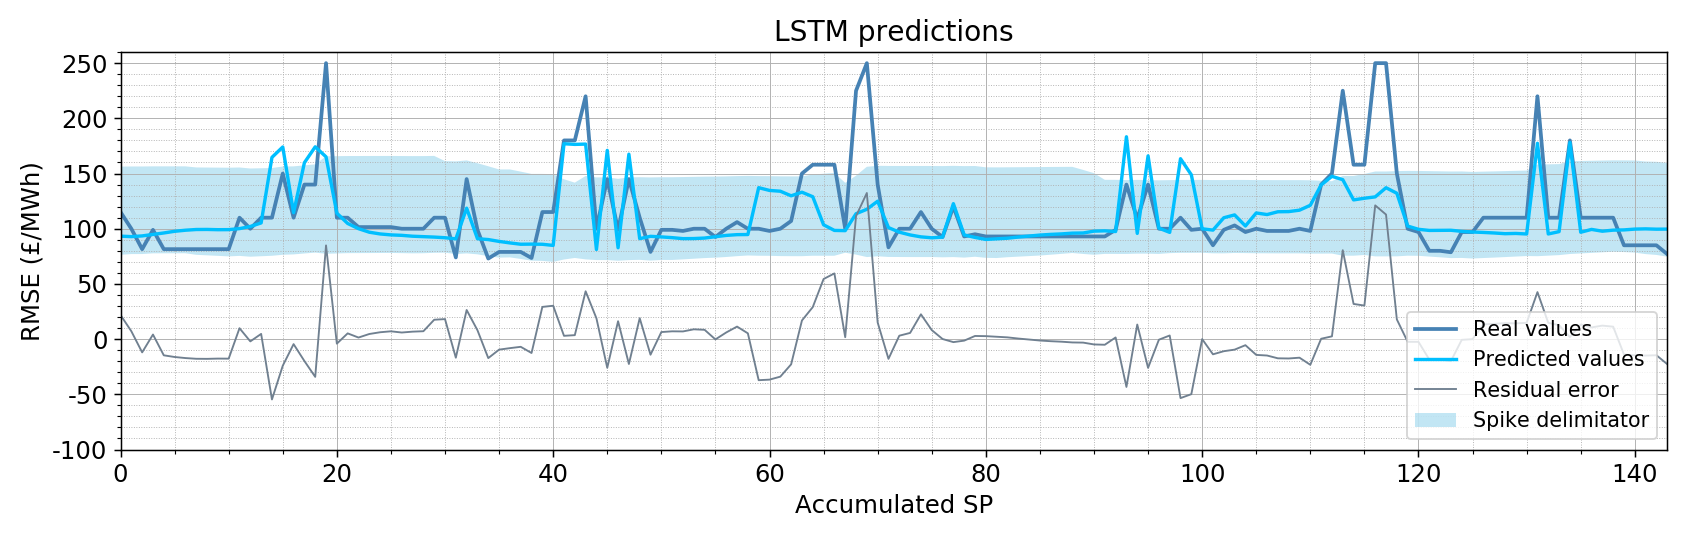

In [67]:
%matplotlib notebook

w_plot = 144 # 3 days
fontsize = 13

y_pred = y_pred.reshape(len(y_pred))

Residual = list(y_test) - y_pred

plt.figure(figsize=(12.5,4))
plt.plot(np.arange(0, 144), y_test[-226:-82], label = 'Real values', linewidth = 2, color = 'steelblue')
plt.plot(np.arange(0, 144), y_pred[-226:-82], label = 'Predicted values', linewidth = 1.8, color= 'deepskyblue')
plt.plot(np.arange(0, 144), Residual[-226:-82], label = 'Residual error', linewidth = 1, color = 'slategrey')
plt.fill_between(np.arange(0, 144),  data['spike_lowerlim'][-226:-82], data['spike_upperlim'][-226:-82], facecolor='skyblue', alpha=0.5, label = 'Spike delimitator')
plt.ylim(-100, 260)
plt.xlim(0, 144 - 1)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Accumulated SP', fontsize = fontsize)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks([-100, -50, 0, 50,100, 150, 200, 250],[-100, -50, 0, 50, 100, 150, 200, 250],  fontsize = fontsize)
plt.title('LSTM predictions', fontsize = fontsize + 2)
plt.legend(loc = 'lower right', fontsize = fontsize - 2)
plt.savefig('LSTTM_prediction.png')
plt.tight_layout()

In [1]:
mse_ = hist.history['mse']
mae_ = hist.history['mae']
val_mse_ = hist.history['val_mse']
val_mae_ = hist.history['val_mae']

rmse = []
mae = []
val_rmse = []
val_mae = []

for j in range(epochs):
    rmse.append(mse_[j] ** 0.5)
    mae.append(mae_[j])
    val_rmse.append(val_mse_[j] ** 0.5)
    val_mae.append(val_mae_[j])
    

NameError: name 'hist' is not defined

In [ ]:
%matplotlib notebook

fontsize = 15

# make them pretty  
fig = plt.figure(figsize = (14,3))

plt.plot(rmse, label = 'Train set')
plt.plot(val_rmse, label = 'Validation set')
plt.xlabel('Accumulated epochs', fontsize = fontsize)
plt.ylabel('RMSE', fontsize = fontsize)
plt.legend(fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlim(0, epochs)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
#plt.title("RMSE during training for 4 months of data with {} epochs".format(epochs), fontsize = fontsize + 2)
plt.savefig('RMSE_training.png')
plt.show()

fig = plt.figure(figsize = (14,3))

plt.plot(mae, label = 'Train set')
plt.plot(val_mae, label = 'Validation set')
plt.legend(fontsize = fontsize)
plt.xlabel('Accumulated epochs', fontsize = fontsize)
plt.ylabel('MAE', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlim(0, epochs)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
#plt.title("MAE during training for 4 months of data with {} epochs".format (epochs), fontsize = fontsize + 2)
plt.savefig('MAE_training.png')
plt.show()